In [1]:
import tensorflow as tf

In [2]:
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

In [4]:
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

In [6]:
content_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')

# https://commons.wikimedia.org/wiki/File:Vassily_Kandinsky,_1913_-_Composition_7.jpg
style_path = tf.keras.utils.get_file('kandinsky5.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')
content_image = load_img(content_path)
style_image = load_img(style_path)

In [7]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

In [27]:
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

In [28]:
resnet50v2 = tf.keras.applications.ResNet50V2(include_top=False, weights='imagenet')

In [10]:
content_layers = ['conv5_block3_1_conv'] 

style_layers = ['conv2_block1_1_conv',
'conv2_block2_1_conv',
'conv3_block1_1_conv',
'conv3_block2_1_conv',
'conv4_block1_1_conv',
'conv4_block2_1_conv',
'conv5_block1_1_conv',
'conv5_block2_1_conv'
]

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [11]:
def resnet50v2_layers(layer_names):
  resnet50v2 = tf.keras.applications.ResNet50V2(include_top=False, weights='imagenet')
  resnet50v2.trainable = False

  outputs = [resnet50v2.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([resnet50v2.input], outputs)
  return model

In [12]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

In [13]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.resnet50v2 =  resnet50v2_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.resnet50v2.trainable = False

  def call(self, inputs):
    "[0,1] 사이의 실수 값을 입력으로 받습니다"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.resnet_v2.preprocess_input(inputs)
    outputs = self.resnet50v2(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name:value 
                    for content_name, value 
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name:value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content':content_dict, 'style':style_dict}

In [14]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

print('스타일:')
for name, output in sorted(results['style'].items()):
  print("  ", name)
  print("    크기: ", output.numpy().shape)
  print("    최솟값: ", output.numpy().min())
  print("    최댓값: ", output.numpy().max())
  print("    평균: ", output.numpy().mean())
  print()

print("콘텐츠:")
for name, output in sorted(results['content'].items()):
  print("  ", name)
  print("    크기: ", output.numpy().shape)
  print("    최솟값: ", output.numpy().min())
  print("    최댓값: ", output.numpy().max())
  print("    평균: ", output.numpy().mean())

스타일:
   conv2_block1_1_conv
    크기:  (1, 64, 64)
    최솟값:  -160.79054
    최댓값:  285.89954
    평균:  8.029386

   conv2_block2_1_conv
    크기:  (1, 64, 64)
    최솟값:  -2.2114253
    최댓값:  3.1866403
    평균:  0.0060812216

   conv3_block1_1_conv
    크기:  (1, 128, 128)
    최솟값:  -5.0140676
    최댓값:  7.7526135
    평균:  0.007340039

   conv3_block2_1_conv
    크기:  (1, 128, 128)
    최솟값:  -1.7390178
    최댓값:  2.0096266
    평균:  0.044565067

   conv4_block1_1_conv
    크기:  (1, 256, 256)
    최솟값:  -4.1237226
    최댓값:  5.770214
    평균:  0.009567199

   conv4_block2_1_conv
    크기:  (1, 256, 256)
    최솟값:  -1.1325629
    최댓값:  1.8558738
    평균:  0.07197705

   conv5_block1_1_conv
    크기:  (1, 512, 512)
    최솟값:  -0.50524294
    최댓값:  0.9105596
    평균:  0.065320745

   conv5_block2_1_conv
    크기:  (1, 512, 512)
    최솟값:  -2.274394
    최댓값:  2.8653712
    평균:  0.115823865

콘텐츠:
   conv5_block3_1_conv
    크기:  (1, 14, 16, 512)
    최솟값:  -1.8399397
    최댓값:  1.3853563
    평균:  -0.14509086


In [15]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

In [16]:
image = tf.Variable(content_image)

In [17]:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [18]:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

In [43]:
style_weight=1e20
content_weight=1e1

In [36]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

In [37]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

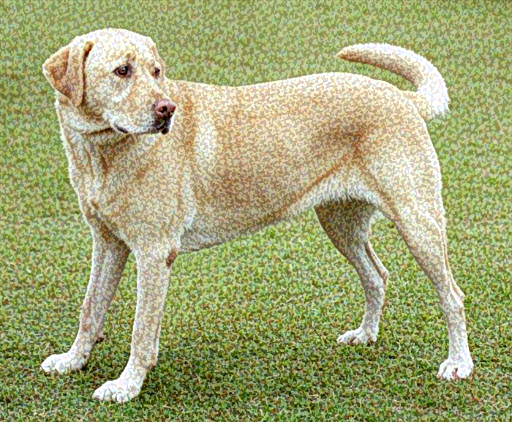

In [44]:
train_step(image)
train_step(image)
train_step(image)
tensor_to_image(image)

In [23]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='')
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("훈련 스텝: {}".format(step))

end = time.time()
print("전체 소요 시간: {:.1f}".format(end-start))

...............................................................................................

KeyboardInterrupt: ignored